<a href="https://colab.research.google.com/github/freyaldi/learn-machine-learning-development/blob/main/time-series/bitstamp_price_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imported libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, pytz

In [2]:
! unzip "/content/drive/MyDrive/Colab Notebooks/dataset/bitstampUSD_1-min_data_2012-01-01_to_2018-11-11.csv.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/dataset/bitstampUSD_1-min_data_2012-01-01_to_2018-11-11.csv.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2018-11-11.csv  


In [21]:
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))


In [22]:
data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-11-11.csv', parse_dates=[0], date_parser=dateparse)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603136 entries, 0 to 3603135
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   Timestamp          datetime64[ns, UTC]
 1   Open               float64            
 2   High               float64            
 3   Low                float64            
 4   Close              float64            
 5   Volume_(BTC)       float64            
 6   Volume_(Currency)  float64            
 7   Weighted_Price     float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 219.9 MB


In [24]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31 07:53:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3603131,2018-11-10 23:55:00+00:00,6348.54,6348.54,6348.54,6348.54,0.007997,50.769274,6348.540000
3603132,2018-11-10 23:56:00+00:00,6348.54,6349.01,6348.54,6349.01,0.011729,74.466671,6348.936090
3603133,2018-11-10 23:57:00+00:00,6349.01,6349.01,6349.01,6349.01,0.068436,434.503642,6349.010000
3603134,2018-11-10 23:58:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# fill forwards those missing values
data['Volume_(BTC)'].fillna(method='ffill', inplace=True)
data['Volume_(Currency)'].fillna(method='ffill', inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31 07:53:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2,2011-12-31 07:54:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
3,2011-12-31 07:55:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
4,2011-12-31 07:56:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
...,...,...,...,...,...,...,...,...
3603131,2018-11-10 23:55:00+00:00,6348.54,6348.54,6348.54,6348.54,0.007997,50.769274,6348.540000
3603132,2018-11-10 23:56:00+00:00,6348.54,6349.01,6348.54,6349.01,0.011729,74.466671,6348.936090
3603133,2018-11-10 23:57:00+00:00,6349.01,6349.01,6349.01,6349.01,0.068436,434.503642,6349.010000
3603134,2018-11-10 23:58:00+00:00,6349.01,6349.01,6349.01,6349.01,0.068436,434.503642,6349.010000


In [26]:
#group the data hourly
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data[['Timestamp', 'Weighted_Price']]
data

,Timestamp,Weighted_Price
0,2011-12-31 07:00:00,4.390000
1,2011-12-31 08:00:00,4.390000
2,2011-12-31 09:00:00,4.390000
3,2011-12-31 10:00:00,4.390000
4,2011-12-31 11:00:00,4.390000
...,...,...
60156,2018-11-10 19:00:00,6352.180000
60157,2018-11-10 20:00:00,6359.310000
60158,2018-11-10 21:00:00,6363.400000
60159,2018-11-10 22:00:00,6363.710000


In [27]:
# Data preprocess
min_max_scaler = MinMaxScaler()
scaled_weighted_price = min_max_scaler.fit_transform(data[['Weighted_Price']])
data['Weighted_Price'] = scaled_weighted_price
data

,Timestamp,Weighted_Price
0,2011-12-31 07:00:00,0.000013
1,2011-12-31 08:00:00,0.000013
2,2011-12-31 09:00:00,0.000013
3,2011-12-31 10:00:00,0.000013
4,2011-12-31 11:00:00,0.000013
...,...,...
60156,2018-11-10 19:00:00,0.324828
60157,2018-11-10 20:00:00,0.325193
60158,2018-11-10 21:00:00,0.325403
60159,2018-11-10 22:00:00,0.325418


In [28]:
#only use data from 2016
data = data.loc[data['Timestamp'] > '2016']
data = data.reset_index()
data = data.drop(columns='index')
data

,Timestamp,Weighted_Price
0,2016-01-01 01:00:00,0.021879
1,2016-01-01 02:00:00,0.021792
2,2016-01-01 03:00:00,0.021820
3,2016-01-01 04:00:00,0.021936
4,2016-01-01 05:00:00,0.022078
...,...,...
25074,2018-11-10 19:00:00,0.324828
25075,2018-11-10 20:00:00,0.325193
25076,2018-11-10 21:00:00,0.325403
25077,2018-11-10 22:00:00,0.325418


In [29]:
# split size
train_size = 0.8
train_rows_num = int(train_size * len(data))
train_rows_num

20063

In [30]:
# split data
data_train = data.loc[data.index <= train_rows_num].copy()
data_val = data.loc[data.index > train_rows_num].copy()

In [31]:
data_train

,Timestamp,Weighted_Price
0,2016-01-01 01:00:00,0.021879
1,2016-01-01 02:00:00,0.021792
2,2016-01-01 03:00:00,0.021820
3,2016-01-01 04:00:00,0.021936
4,2016-01-01 05:00:00,0.022078
...,...,...
20059,2018-04-15 20:00:00,0.424721
20060,2018-04-15 21:00:00,0.423648
20061,2018-04-15 22:00:00,0.425044
20062,2018-04-15 23:00:00,0.426987


In [32]:
data_val

,Timestamp,Weighted_Price
20064,2018-04-16 01:00:00,0.429831
20065,2018-04-16 02:00:00,0.426864
20066,2018-04-16 03:00:00,0.417061
20067,2018-04-16 04:00:00,0.417396
20068,2018-04-16 05:00:00,0.416428
...,...,...
25074,2018-11-10 19:00:00,0.324828
25075,2018-11-10 20:00:00,0.325193
25076,2018-11-10 21:00:00,0.325403
25077,2018-11-10 22:00:00,0.325418


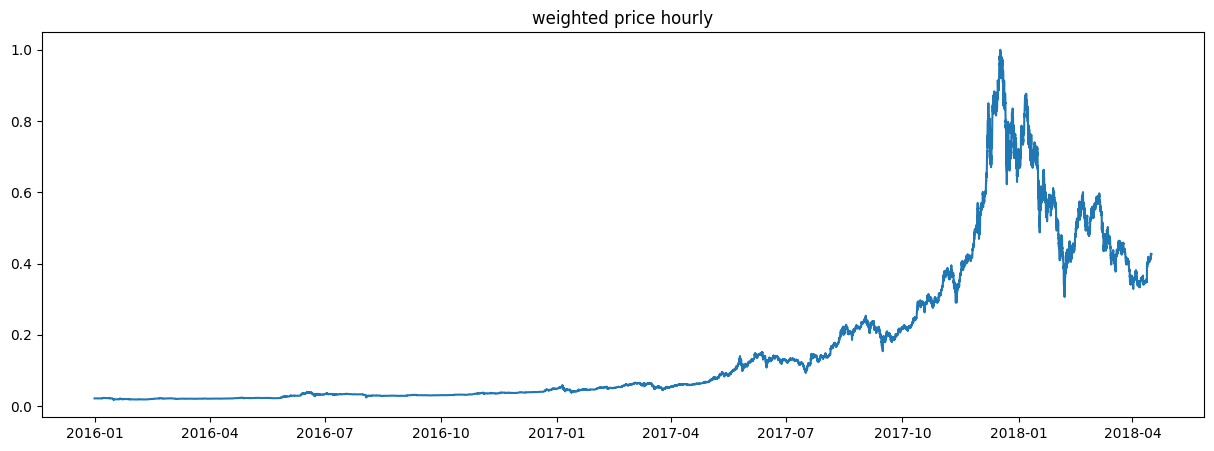

In [33]:
timestamps = data_train['Timestamp'].values
weighted_price  = data_train['Weighted_Price'].values

plt.figure(figsize=(15,5))
plt.plot(timestamps, weighted_price)
plt.title('weighted price hourly');

In [34]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [39]:
train_set = windowed_dataset(data_train['Weighted_Price'].values, window_size=160, batch_size=128, shuffle_buffer=1000)
val_set = windowed_dataset(data_val['Weighted_Price'].values, window_size=160, batch_size=128, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                             strides=1,
                             activation="relu",
                             padding='causal',
                             input_shape=[160, 1]),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [40]:
#determine the threshold of mae < 5 % scale of data
threshold_mae = (data['Weighted_Price'].max() - data['Weighted_Price'].min()) * 5/100
threshold_mae

0.049101485354478065

In [41]:
#create two callbacks
def scheduler(epoch, lr):
  if epoch % 10 != 0 or epoch == 0:
    return lr
  return lr * tf.math.exp(-0.1)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae):
      self.model.stop_training = True

scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = myCallback()

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "accuracy"])
history = model.fit(train_set, validation_data=val_set, epochs=100, callbacks=[callbacks, scheduler])

Epoch 1/100
156/156 [==============================] - 66s 377ms/step - loss: 0.0140 - mae: 0.0918 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_mae: 0.0447 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
156/156 [==============================] - 71s 450ms/step - loss: 0.0160 - mae: 0.1246 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_mae: 0.0578 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
156/156 [==============================] - 60s 381ms/step - loss: 0.0118 - mae: 0.1053 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_mae: 0.0666 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
156/156 [==============================] - 59s 376ms/step - loss: 0.0085 - mae: 0.0891 - accuracy: 5.0241e-05 - val_loss: 0.0032 - val_mae: 0.0747 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
156/156 [==============================] - 59s 375ms/step - loss: 0.0061 - mae: 0.0752 - accuracy: 5.0241e-05 - val_loss: 0.0027 - val_mae: 0.0706 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch

In [43]:
#plot function
def show_plot(train_plot, val_plot, title):
  plt.plot(train_plot)
  plt.plot(val_plot)
  plt.title(title)
  plt.ylabel(title)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

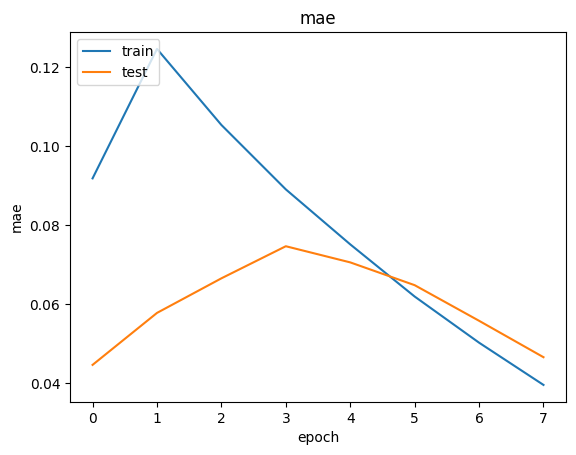

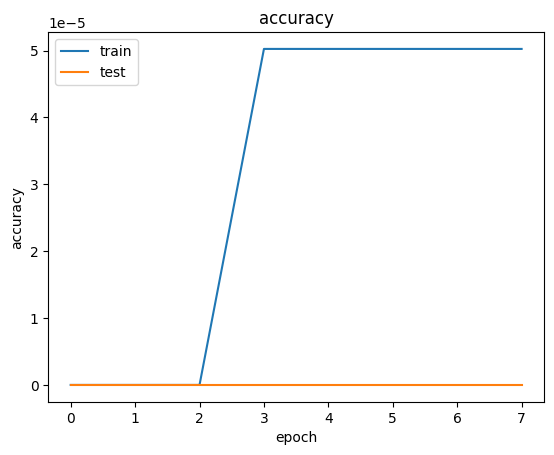

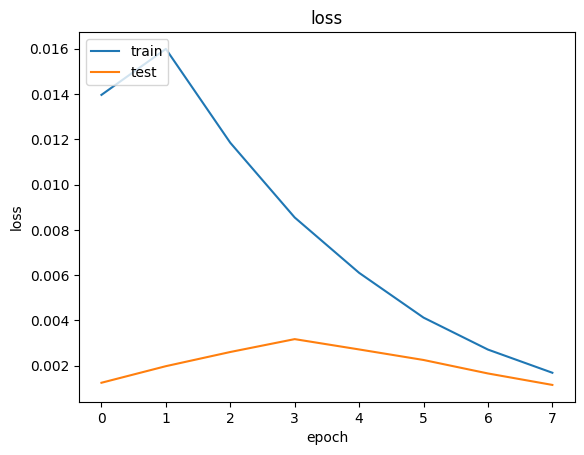

In [44]:
#visualize mae, accuracy, and loss progress
show_plot(history.history['mae'], history.history['val_mae'], 'mae')
show_plot(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')
show_plot(history.history['loss'], history.history['val_loss'], 'loss')